**MSCI 446 - Project Report**
# Handwriting Recognition using CNN
### *Carman Li, Glen Wu, Jiaru Cao, Yzabelle Go*
---





# 1. Introduction

Taking and reading notes is an important part of many post-secondary students. While taking notes by keyboard is a readily available choice, many students still prefer to take notes by hand, and not all students have access to expensive tablets or pens. However, there are not many options to digitize notes that are taken by hand. Thus, this project’s goal is to create a solution for students that will allow them to convert handwritten note images into digital text.

In addition, the technology can be applied to digitize other kinds of records, including handwritten financial documents, such as cheques and invoices. This functionality is critical in many financial industries, who often leverage powerful automated accounting tools. Another application is to digitize historical documents, as there are many delicate pieces of ancient writing and history that are currently being preserved by museums and universities around the world. If all these records were able to be digitized, it would greatly increase their accessibility, as well as ensure that they can be studied in the future if their physical copies degrade [1].

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from prettytable import PrettyTable
from statistics import mean, median, mode
import time

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

C:\Users\Yzabelle\miniconda3\envs\tf\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


In [ ]:
DEVICE_NAME = tf.test.gpu_device_name()
if len(DEVICE_NAME) > 0:
    print("Found GPU at: {}".format(DEVICE_NAME))
    !nvidia-smi
else:
    DEVICE_NAME = "/device:CPU:0"
    print("No GPU, using {}.".format(DEVICE_NAME))

Found GPU at: /device:GPU:0
Thu Apr  6 16:29:10 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.41                 Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070       WDDM | 00000000:2B:00.0  On |                  N/A |
|  0%   46C    P2               52W / 220W|   1572MiB /  8192MiB |      6%      Default |
|                                         |                      |                  N/A |
+---------------------------------------

# 2. Data Description

### Dataset Information & Visualizations
The dataset that will be used in this project is part of the IAM (International Association for Pattern Recognition) Handwriting Database, version 3.0. This database was first published in 1999 and contains a widely used collection of handwritten text images for the training and evaluation of machine learning algorithms in the field of handwriting recognition [2]. It includes over 100,000 images from 657 writers, in the form of scanned pages, sentences, text lines, and words [3]. The data is publicly accessible and freely available for non-commercial research purposes [4]. For the purposes of this project, the 115,320 PNG images of the isolated and labeled words will be used. These can be downloaded from the FKI: Research Group on Computer Vision and Artificial Intelligence’s site, located here: [Download the IAM Handwriting Database](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database) [4].

Figure 1: Sample word images from the IAM dataset
> 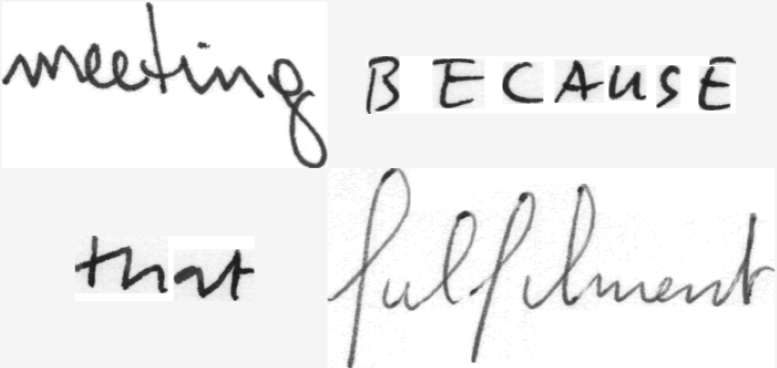

Each image in the dataset consists of a single word of handwritten text, which were extracted from pages that “were scanned at a resolution of 300dpi and saved as PNG images with 256 gray levels” [3]. This process was completed using an automatic segmentation scheme, with manual verification [3]. The height and width dimensions vary from picture to picture. Figure 1 above shows some samples of these words, in the handwriting of different authors. All images also have their own corresponding XML meta-information. This includes segmentation information, such as the original sentence it was from, and other estimated parameters, shown in Figure 2 [3].

Figure 2: The word “AND” with corresponding metadata on approximate character positions

>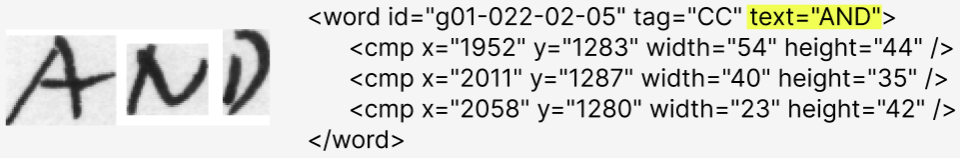

The data is split into 76 folders at the top level, with the naming convention of a01, a02, etc. until r06. Each one of these parent folders contain subfolders which have a set of images. An example of this structure is shown in Figure 3. For the image name formats of a01-000u-00-00.png, the information provided would be as follows: (unspecified id)-(writer id)-(line id)-(word id).png.




Figure 3: IAM word dataset folder structure
> 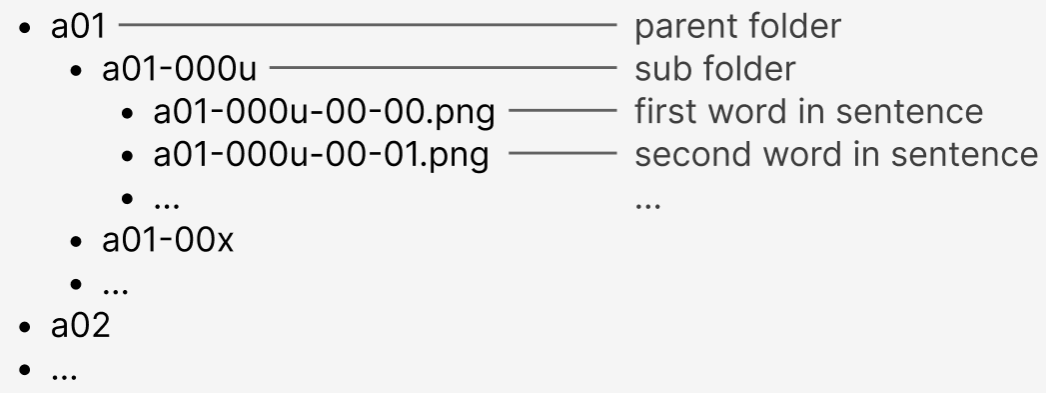

Along with the dataset is a provided annotation .txt file that mentions the path to image files and the corresponding transcriptions. Each of the 115,320 rows follows the format of:
<br><br/>
**a01-000u-00-00 ok 154 1 408 768 27 51 AT A**
<br><br/>
Where each portion of the string is described in Table 1. Additional row samples are depicted in Figure 4.

Table 1: Image representation in annotation file [5]
>| String Portion     	| Meaning                                                                                                       	|
|--------------------	|---------------------------------------------------------------------------------------------------------------	|
| **a01-000u-00-00** 	| Word id for line 00 in form a01-000u                                                                          	|
| **ok**             	| Result of word segmentation<br>   ok: word was segmented correctly<br>   err: segmentation of word can be bad 	|
| **154**            	| Graylevel to binarize the line containing this word                                                           	|
| **1**              	| Number of components for this word                                                                            	|
| **408 768 27 51**  	| Bounding box around this word in x,y,w,h format                                                               	|
| **AT**             	| The grammatical tag for this word [6]                                                                         	|
| **A**              	| The transcription for this word                                                                               	|

Figure 4: Sample rows from the word dataset annotation file
> 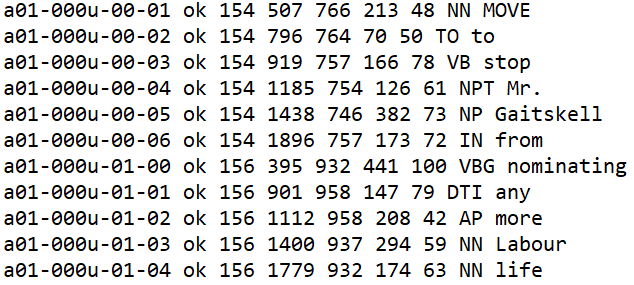

For line recognition, the IAM database defines a task that partitions the data into training, validation, and testing sets. The “text lines of all data sets are mutually exclusive, thus each writer has contributed to one set only” [3]. Mutual exclusivity is important to ensure that the program is tested on how well it performs on new, unseen data, rather than on recognition. These sets can be adapted for use with word recognition, since the line ids only omit the specific word ids for correlated images. They would serve well as an initial starting point to tweak and build off of.  

Overall, the IAM database provides a solid foundation for the development of a handwriting recognition algorithm. The included images and their corresponding information will be paramount to the success of the machine learning algorithm.


## Data Summary

In total, there are 96456 words in the dataset that we are working with. The training, testing, and validate sets have 86810, 4823, and 4823 elements in them, respectively. Charts and tables showing character distribution and summary statistics will be shown below.

> Note: In the code block below, we can see how many words are in the dataset.

In [ ]:
script_dir = os.path.abspath('')
rel_path = "data/words.txt"
text_file = os.path.join(script_dir, rel_path)
rel_folder_path = 'data/words/'
image_file = os.path.join(script_dir, rel_folder_path)

list_of_words = []
label_file = open(text_file, 'r').readlines()

for line in label_file:
    # ignore commented lines
    if line[0] == "#":
        continue
    # only get "ok" entries
    if line.split(" ")[1] == "ok":
        list_of_words.append(line)

# total number of words in the dataset we will be working with
print(f"Total words: {len(list_of_words)}")
print(list_of_words[:10])

Total words: 96456
['a01-000u-00-00 ok 154 408 768 27 51 AT A\n', 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n', 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n', 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n', 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n', 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell\n', 'a01-000u-00-06 ok 154 1896 757 173 72 IN from\n', 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating\n', 'a01-000u-01-01 ok 156 901 958 147 79 DTI any\n', 'a01-000u-01-02 ok 156 1112 958 208 42 AP more\n']


> Note: In the code block below, we split our full list of words into train/test/validate sets, using ratios defined below. We can also see how many elements are in each set.

In [ ]:
TRAIN_RATIO = 0.9
VAL_RATIO = 0.5

training_data = []
validation_data = []
testing_data = []

# split data into training, testing, validation sets
total_words = len(list_of_words)
training_indexes = int(TRAIN_RATIO * total_words)
split_test_and_val = int(VAL_RATIO * (total_words-training_indexes))
testing_indexes = training_indexes - split_test_and_val
validation_indexes = -split_test_and_val

training_data = list_of_words[:training_indexes]
testing_data = list_of_words[testing_indexes:training_indexes]
validation_data = list_of_words[validation_indexes:]


print(f"Train/Val/Test: {len(training_data)}/{len(validation_data)}/{len(testing_data)}")

Train/Val/Test: 86810/4823/4823


> Note: Here we are just initializing variables we will need later on.
>* *char list*: what one ml layer will be trying to sort different chars into
>* *longest_label_length*: used to help resize the images
>* *batch_size*: number of training examples used in 1 iteration -> smaller generally faster, but less accurate
>* *pad_with_val*: fills label vectors with this value so that they are all the same length  
   

In [ ]:
# Init needed variables
full_char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
char_array = [c for c in full_char_list]

longest_label_length = 21
new_image_size = (64, 128)

# setting to 99 so it is not associated w a char in the char array
pad_with_val = 99

## Data Manipulation

Before using the data, it was first cleaned. The quality of the source image is an important factor that can impact the accuracy of our model. Specifically, ensuring that the desired text was legible and defined clearly as the foreground data would help reduce the amount of noise present in our learning process. This cleaning process commonly includes smoothing text, applying adaptive thresholding to isolate the foreground objects and transforming an image into black and white, removing grid lines, removing noise and speckles, and rotating text [7]. Since the IAM source images already contained single words, there was no need for trimming or cropping the images to isolate for individual words. Additionally, no noise removal techniques were applied since the IAM images already included plain backgrounds.

However, the data was transformed. The images were first loaded and then normalized. Although the IAM source images contained plain backgrounds, they were still in grayscale. Thus, normalization was applied to convert the pixels in each image to contain either the value of 0 or 255. The pixel values were then divided by a value of 255 to scale the values to be in the range of [0, 1], and then rounded to either be 0 or 1, which corresponds to black and white, respectively. The process of normalization is critical because it helps our model to converge faster during training by making the input values smaller, more consistent, and reducing skewness [8]. After normalization, the input images were then resized to a uniform size of 64px by 128px. For images that were smaller than the desired canvas size, the image was scaled up and filled with white pixels.


In [ ]:
# Read file paths and labels and loads the image
def get_data_from_files(data):
    img_paths = []
    img_label = []
    for element in data:
        element = element.strip().split(" ")
        image_name = element[0]
        first_section, second_section = image_name.split("-")[:2]
        img_path = os.path.join(image_file, first_section, f"{first_section}-{second_section}", f"{image_name}.png")
        # using getsize to avoid any 0 size images
        if os.path.getsize(img_path):
            img_paths.append(img_path)
            img_label.append(element[-1])

    return img_paths, img_label

# Encode the label into tensor of numeric values that are all padded to equal
# length
def encode_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    padding_amount = longest_label_length - tf.shape(label)[0]
    label = tf.pad(label, paddings=[[0, padding_amount]], constant_values=pad_with_val)
    return label

# Pad and resize images without distorting them
def preprocess_image(image_path):
    # load image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    # scale image to new size
    image = tf.image.resize(image, size=(new_image_size[0], new_image_size[1]), preserve_aspect_ratio=True)
    # add black padding
    image = tf.pad(
        image,
        paddings=[[0, new_image_size[0] - tf.shape(image)[0]], [0, new_image_size[1] - tf.shape(image)[1]], [0, 0]],
    )
    # transpose to avoid distortion
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)

    # normalize image
    image = tf.cast(image, tf.float32) / 255.0
    return image

def format_data(image_path, label):
    image = preprocess_image(image_path)
    label = encode_label(label)
    return {"image": image, "label": label}

def create_ds(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        format_data, num_parallel_calls=tf.data.AUTOTUNE
    )
    return dataset.batch(32).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
char_to_num = StringLookup(vocabulary=list(char_array))
num_to_char = StringLookup(vocabulary=list(char_array), invert=True)

def uncode_label(label):
    indices = tf.gather(label, tf.where(tf.math.not_equal(label, pad_with_val)))
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    return label

# Use indices earlier to get each portion of the dataset training_paths, training_labels = get_data_from_files(training_data)
validation_paths, validation_labels = get_data_from_files(validation_data)
testing_paths, testing_labels = get_data_from_files(testing_data)

prepared_training_dataset = create_ds(training_paths, training_labels)
prepared_validation_dataset = create_ds(validation_paths, validation_labels)
prepared_testing_dataset = create_ds(testing_paths, testing_labels)

# Create batches for validation
validation_images = []
validation_labels = []

for batch in prepared_validation_dataset:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

> Note: The code block below shows a sample image and its label after the data preprocessing steps detailed above.

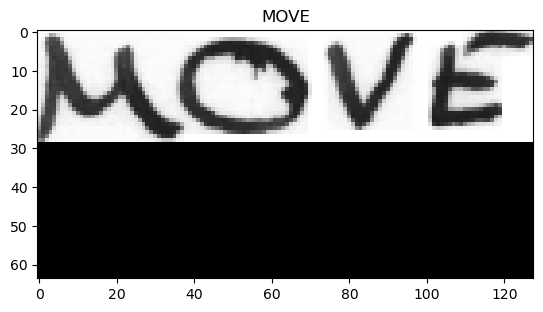

In [ ]:
# show sample img + label after processing
for img in prepared_training_dataset.take(1):
    image, label = img["image"][1], img["label"][1]
    image = tf.image.flip_left_right(image)
    image = tf.transpose(image, perm=[1, 0, 2])

    label = uncode_label(label)

    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(label)

> Note: The code block below generates a graph of the character distribution in our dataset. A table of summary statistics is also shown.

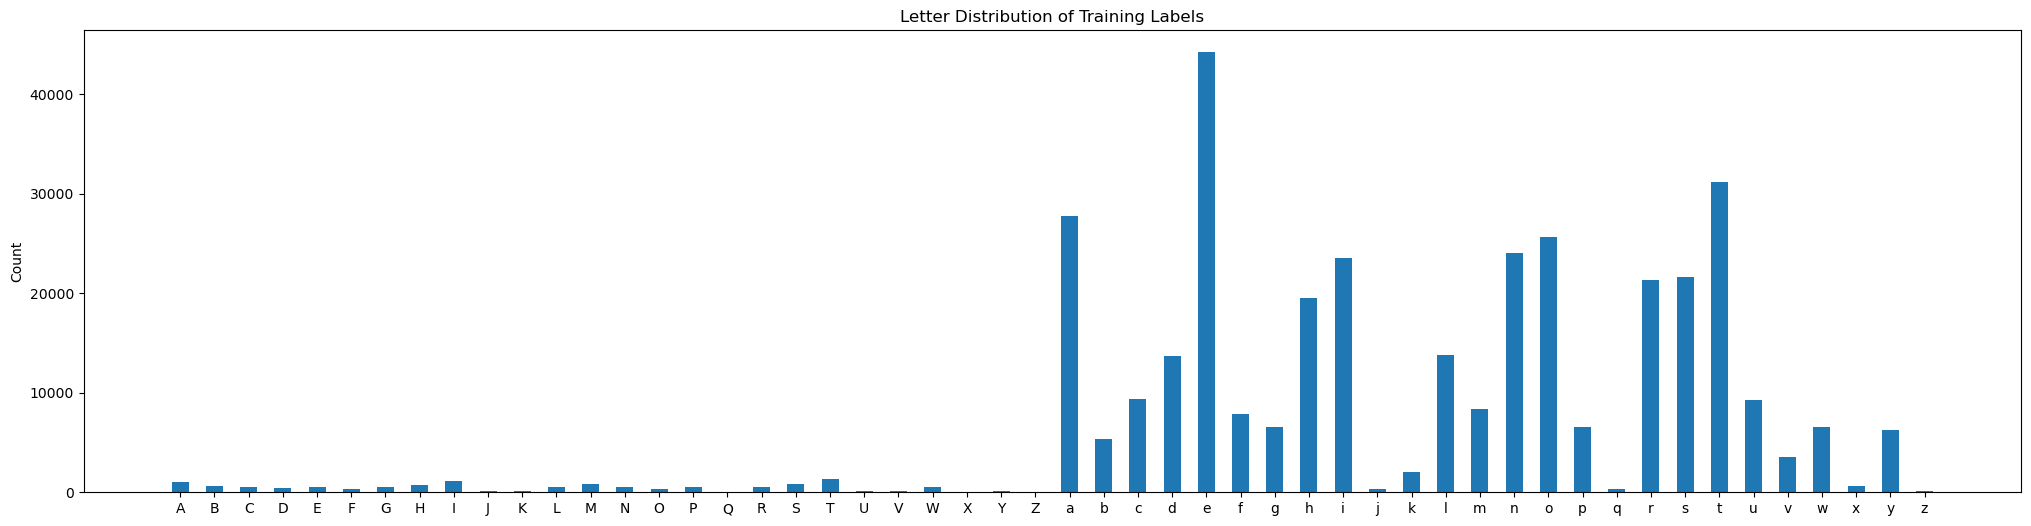

+------------------------------+-------------------+
|      Summary Statistics      |       Value       |
+------------------------------+-------------------+
|         Mean Length          | 4.212489488417099 |
|        Median Length         |         4         |
|         Mode Length          |         3         |
| Total # of Labels in Dataset |       86809       |
+------------------------------+-------------------+


In [ ]:
def letter_distribution(labels, title):
    alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
    # Punctuation has been omitted here for clairty in the chart, but the model does account for it
    counts = np.zeros(len(alphabet))
    for label in labels:
        for char in label:
            if char in alphabet:
                index = alphabet.index(char)
                counts[index] += 1
    x = np.arange(len(alphabet))
    fig, ax = plt.subplots(figsize=(25, 6))
    ax.bar(x, counts, width=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(list(alphabet))
    ax.set_ylabel('Count')
    ax.set_title(f'Letter Distribution of {title} Labels')
    plt.show()

def length_stats(labels):
    lengths = [len(label) for label in labels]
    mean_length = mean(lengths)
    median_length = median(lengths)
    mode_length = mode(lengths)
    number_of_labels = len(labels)
    return {'mean': mean_length, 'median': median_length, 'mode': mode_length, 'number_of_labels': number_of_labels}

# Data vis training data
letter_distribution(training_labels, "Training")
stats = length_stats(training_labels)

table = PrettyTable()
table.field_names = ['Summary Statistics', 'Value']
table.add_row(['Mean Length', stats['mean']])
table.add_row(['Median Length', stats['median']])
table.add_row(['Mode Length', stats['mode']])
table.add_row(['Total # of Labels in Dataset', stats['number_of_labels']])
print(table)

# Machine Learning

In [ ]:
# Compute the CTC loss for a given input-output pair and add it to the overall model loss during training.
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # compute loss value
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

## Test Run

To simplify the problem and for the team to learn how to properly use CNN models, the first iteration of building our model included only using one-digit sample inputs from the MINST dataset. The MINST dataset was loaded directly through Keras. Two layers were implemented in the CNN model. A result of 99% accuracy was achieved. Following this test iteration, the model was iterated upon to support words as inputs. This became Iteration 1, the results of which will be shown in the following section.

In [ ]:
# First Attempt at a model for Handwriting OCR
def build_seq_model():
    input_img = keras.Input(shape=(new_image_size[1], new_image_size[0], 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # first convolution
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="ConLayer1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second convolution
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="ConLayer2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # the convolution layers downsized the feature maps, so we will need
    # to reshape them before moving on to our RNN layers
    new_shape = ((new_image_size[1] // 4), (new_image_size[0] // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="DenseLayer1")(x)
    x = keras.layers.Dropout(0.2)(x)

    x = keras.layers.Dense(128, activation="relu", name="DenseLayer2")(x)
    x = keras.layers.Dropout(0.2)(x)

    # output layer
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="DenseLayer3"
    )(x)

    # calculate CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define our model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # chosen optimizer = SGD
    opt = keras.optimizers.SGD()

    model.compile(optimizer=opt)
    return model

seq_model = build_seq_model()
seq_model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 ConLayer1 (Conv2D)             (None, 128, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 32, 32)   0           ['ConLayer1[0][0]']              
                                                                                                  
 ConLayer2 (Conv2D)             (None, 64, 32, 64)   18496       ['pool1[0][0

## Results


### Iteration 1

In [ ]:
# FIRST ITERATION
seq_model = build_seq_model()

# using real-time instead of processing time for runtime
seq_start = time.perf_counter()
seq_history = seq_model.fit(
    prepared_training_dataset,
    validation_data=prepared_validation_dataset,
    epochs=5,
    verbose=1,
)
seq_end = time.perf_counter()
seq_runtime = round((seq_end - seq_start), 2)

Epoch 1/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.9050 - val_loss: 53.9419
Epoch 2/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 3/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 4/5
2713/2713 [==============================] - 91s 34ms/step - loss: 57.8797 - val_loss: 53.9419
Epoch 5/5
2713/2713 [==============================] - 90s 33ms/step - loss: 57.8797 - val_loss: 53.9419



Looking at the training results of this model, we can see that neither the loss nor validation loss is converging to a lower value. This means that during the training stage, the model was unable to reach a stable state where loss was at a minimum and parameters weren’t changing significantly. This model also had a very high loss value, meaning its predicted output was very different from the expected output and thus, was unable to properly classify handwritten text. A reason for this model’s underperformance is data quality. Any outliers, noise, or inconsistency in the data could have skewed our results. The possible negative effects of this were mitigated in our process by using a dataset from a trusted source (as opposed to collecting data ourselves), as well as through our data preprocessing and cleaning steps. However, these steps could possibly be improved upon. Another reason for the model’s underperformance is hyperparameters with incorrect settings. As such, we chose to tune some of the model’s hyperparameters for the next iteration.

An interesting outcome from the first iteration of the model is that it predicted the same thing for every image passed through it. We found that we were able to avoid this outcome in the next iteration by tuning the model’s hyperparameters. However, this could have also been caused by overfitting, where the model was fit exactly to its training data, making it unable to perform with unseen data [16].  In general, we did not expect the severity of this model’s underperformance, especially because much of the model’s structure was similar to that of our test run.


### Iteration 2

To improve upon Iteration 1, multiple parameters that are used in our CNN model were adjusted to improve the accuracy of our model. Specifically, hyperparameters, including the number of epochs, the number of layers in the model, and the optimizer type were experimented with to create Iteration 2.

Table 2: Summary of parameter adjustments between Iterations 1 and 2.

>| **Parameter**        	| **Iteration 1** 	| **Iteration 2**                        	|
|----------------------	|-----------------	|----------------------------------------	|
| **Number of epochs** 	| 5               	| 10                                     	|
| **Number of layers** 	| 2 CNN layers    	| Added 2 RNN layers and a 3rd CNN layer 	|
| **Optimizer**        	| SGD             	| Adam                                   	|

In [ ]:
def build_final_model():
    # inputs to the model
    input_img = keras.Input(shape=(new_image_size[1], new_image_size[0], 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # first convolution
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second convolution
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # third convolution
    x = keras.layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="convolution3",
    )(x)

    x = keras.layers.MaxPooling2D((2, 2), name="pool3")(x)

    x = tf.keras.layers.UpSampling2D(
        size=(2, 2), data_format=None, interpolation="nearest"
    )(x)

    # the convolution layers downsized the feature maps, so we will need
    # to reshape them before moving on to our RNN layers
    new_shape = ((new_image_size[1] // 4), (new_image_size[0] // 4) * 128)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # CTC Loss Layer introduces 2 extra symbols, therefore this is accounted for here.
    # The infomration comes here: https://github.com/MaybeShewill-CV/CRNN_Tensorflow/issues/69#issuecomment-383992527.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # add CTC layer is added
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define our model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="OCR_HANDWRITING_MODEL"
    )

    # use ADAM over SGD in this iteration
    opt = keras.optimizers.Adam()

    model.compile(optimizer=opt)
    return model

final_model = build_final_model()
final_model.summary()

Model: "OCR_HANDWRITING_MODEL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 convolution1 (Conv2D)          (None, 128, 64, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 32, 32)   0           ['convolution1[0][0]']           
                                                                                                  
 convolution2 (Conv2D)          (None, 64, 32, 64)   18496       ['pool1[0][0]

In [ ]:
final_prediction_model = keras.models.Model(
    final_model.get_layer(name="image").input, final_model.get_layer(name="dense2").output
)

final_start = time.perf_counter()
final_history = final_model.fit(
    prepared_training_dataset,
    validation_data=prepared_validation_dataset,
    epochs=10
)
final_end = time.perf_counter()
final_runtime = round((final_end - final_start), 2)

Epoch 1/10
2713/2713 [==============================] - 136s 50ms/step - loss: 2.0953 - val_loss: 2.4360
Epoch 2/10
2713/2713 [==============================] - 137s 51ms/step - loss: 2.0615 - val_loss: 2.3157
Epoch 3/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.9998 - val_loss: 2.5410
Epoch 4/10
2713/2713 [==============================] - 135s 50ms/step - loss: 1.9409 - val_loss: 2.4199
Epoch 5/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.9009 - val_loss: 2.3728
Epoch 6/10
2713/2713 [==============================] - 137s 50ms/step - loss: 1.8476 - val_loss: 2.3581
Epoch 7/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.8025 - val_loss: 2.3666
Epoch 8/10
2713/2713 [==============================] - 137s 51ms/step - loss: 1.7653 - val_loss: 2.3236
Epoch 9/10
2713/2713 [==============================] - 136s 50ms/step - loss: 1.7451 - val_loss: 2.2946
Epoch 10/10
2713/2713 [==============================] 

> Note: The code block below shows a given image and its predicted text using the model.

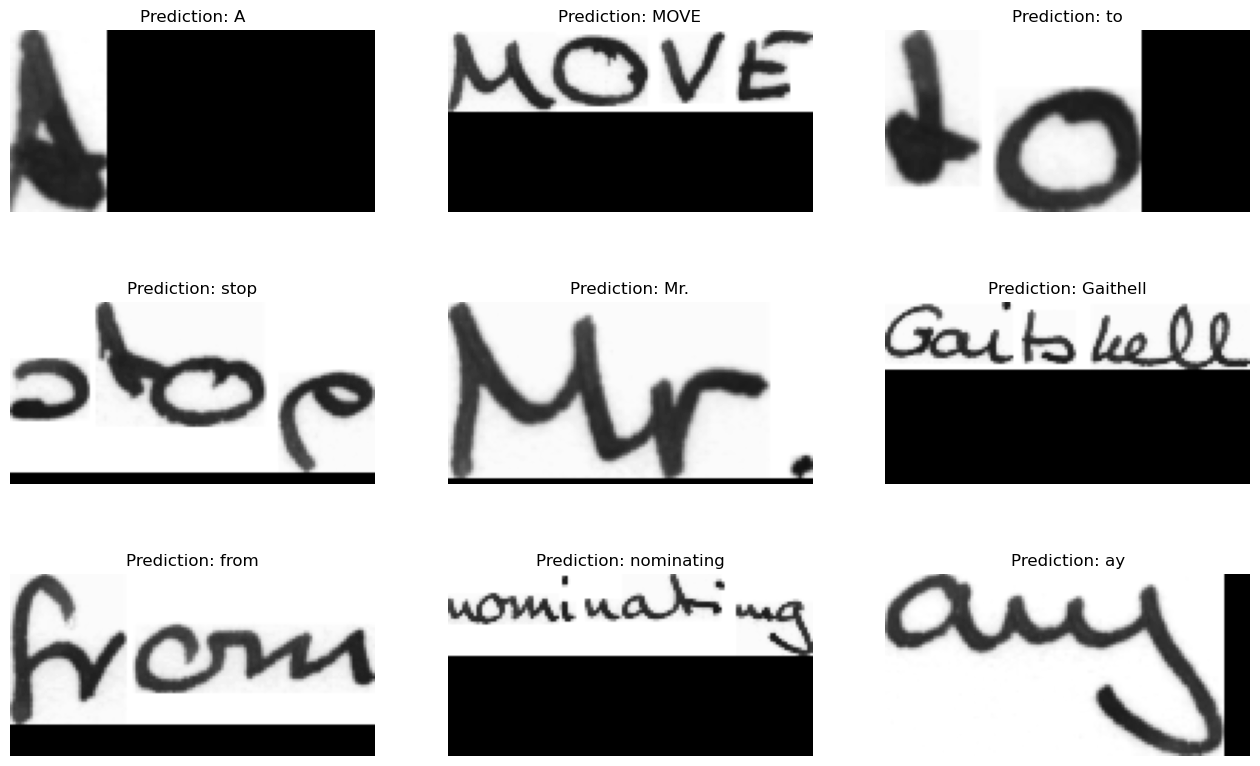

In [ ]:
#This function takes in a prediction tensor and uses the CTC algorithm
#to decode the predicted text from the tensor
def decode_predictions(prediction):
    prediction_shape = prediction.shape
    input_len = np.ones(prediction_shape[0]) * prediction_shape[1]

    results = keras.backend.ctc_decode(prediction, input_length=input_len, greedy=True)[0][0][:, :22]
    predicted_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        predicted_text.append(res)
    return predicted_text

# show images and their predicted text
for batch in prepared_training_dataset.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(3, 3, figsize=(16, 10))

    preds = final_prediction_model.predict(batch_images, verbose = 0)
    pred_texts = decode_predictions(preds)

    for i in range(9):
        axis = ax[i // 3, i % 3]
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])

        title = f"Prediction: {pred_texts[i]}"
        axis.axis("off")
        axis.imshow(img, cmap=plt.cm.gray)
        axis.set_title(title)

plt.show()

### Loss Plots

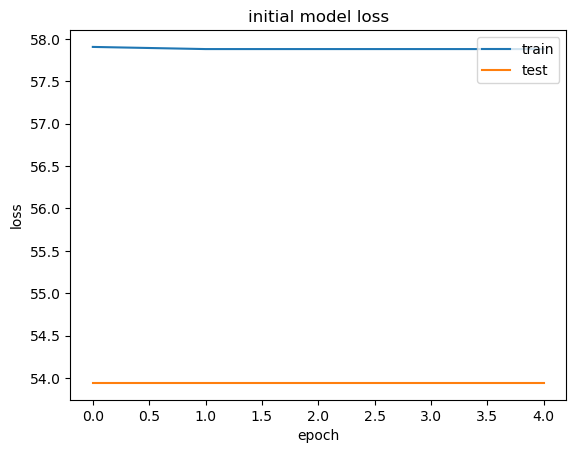

Initial model runtime: 450.61


In [ ]:
# plot initial iteration loss
plt.plot(seq_history.history['loss'])
plt.plot(seq_history.history['val_loss'])
plt.title('initial model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print(f"Initial model runtime: {seq_runtime}")

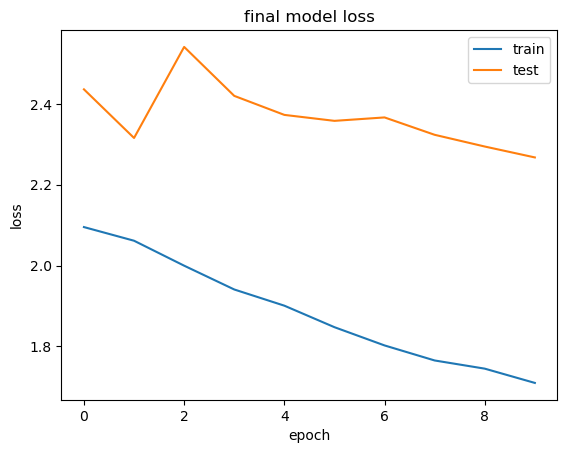

Final model runtime: 1362.8


In [ ]:
# plot final iteration loss
plt.plot(final_history.history['loss'])
plt.plot(final_history.history['val_loss'])
plt.title('final model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

print(f"Final model runtime: {final_runtime}")

When comparing the plots for both iterations, we can see that Iteration 2 had much lower loss values. The runtime is about three times higher, which is expected due to the increased number of epochs. The shape of the loss curve for the second iteration is much closer to an ideal shape.

In the second iteration, we can see that testing loss is higher than training loss, which could be indicative of overfitting. This could be one of the reasons why this model has a relatively low accuracy.

### Accuracy Calculations

In [ ]:
# prep functions for finding accuracy
correct_labels = []
for element in prepared_training_dataset.as_numpy_iterator():
    correct_labels.append(element["label"])


def uncode_labels(labels):
    uncoded_labels = []
    for label in labels:
        label = uncode_label(label)
        uncoded_labels.append(label)

    return uncoded_labels


def get_predicted_labels(i):
    # edge case for 0, nothing to skip
    if i == 0:
        for batch in prepared_training_dataset.take(1).prefetch(1):
            batch_images = batch["image"]
            preds = final_prediction_model.predict(batch_images, verbose = 0)
            pred_texts = decode_predictions(preds)
    else:
        for batch in prepared_training_dataset.skip(i).take(1).prefetch(1):
            batch_images = batch["image"]
            preds = final_prediction_model.predict(batch_images, verbose = 0)
            pred_texts = decode_predictions(preds)

    return pred_texts

print("Original text:")
print(uncode_labels(correct_labels[0]))
print("Predicted text:")
print(get_predicted_labels(0))

Original text:
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaitskell', 'from', 'nominating', 'any', 'more', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'put', 'down', 'a', 'resolution', 'on', 'the', 'subject', 'Griffiths', ',', 'P']
Predicted text:
['A', 'MOVE', 'to', 'stop', 'Mr.', 'Gaithell', 'from', 'nominating', 'ay', 'mone', 'Labour', 'life', 'Peers', 'is', 'to', 'be', 'made', 'at', 'a', 'meeting', 'of', 'Labour', 'put', 'down', 'a', 'resoution', 'on', 'the', 'subject', 'oriftiths', ',', 'wp']


In [ ]:
# Calculate accuracy -> if one character is off, it counts as the whole word being wrong (case-sensitive)
# improvement would be to use a distance metric
accuracy = 0
differences = 0
total = 0

# initialize vars for edit distance calculation
correct_list = []
predicted_list = []

for i in range(len(correct_labels)):
    correct_array = uncode_labels(correct_labels[i])
    predicted_array = get_predicted_labels(i)

    correct_list += correct_array
    predicted_list += predicted_array

    if len(correct_array) != len(predicted_array):
        continue
    else:
        total += len(correct_array)
        if (i % 200 == 0):
            print(f"Progress: {i}/{len(correct_labels)}")
        for j in range(len(correct_array)):
            if correct_array[j] != predicted_array[j]:
                differences += 1

print(f"Accuracy: {differences/total * 100}")

Progress: 0/2713
Progress: 200/2713
Progress: 400/2713
Progress: 600/2713
Progress: 800/2713
Progress: 1000/2713
Progress: 1200/2713
Progress: 1400/2713
Progress: 1600/2713
Progress: 1800/2713
Progress: 2000/2713
Progress: 2200/2713
Progress: 2400/2713
Progress: 2600/2713
Accuracy: 26.842838876153397


In [ ]:
# Since accuracy is only looking at exact matches of the string, lets use
# edit distance to see how far our model is off
# Edit distance is the number of inserations removals or edits required
# to reach the same label

def edit_distance(correct_list, predicted_list):
    distances = []
    total_distance = 0
    for i in range(len(correct_list)):
        word1 = correct_list[i]
        word2 = predicted_list[i]
        n = len(word1)
        m = len(word2)
        distance_matrix = np.zeros((n+1, m+1))

        for i in range(n+1):
            distance_matrix[i][0] = i
        for j in range(m+1):
            distance_matrix[0][j] = j
        for i in range(1, n+1):
            for j in range(1, m+1):
                if word1[i-1] == word2[j-1]:
                    distance_matrix[i][j] = distance_matrix[i-1][j-1]
                else:
                    distance_matrix[i][j] = 1 + min(distance_matrix[i][j-1], distance_matrix[i-1][j], distance_matrix[i-1][j-1])
        distance = distance_matrix[n][m]
        distances.append(distance)
        total_distance += distance
    mean_distance = total_distance / len(correct_list)
    return mean_distance

edit_distance(correct_list, predicted_list)

0.44044972295499313

>Note: Edit distance is a measure of the similarity between two strings. It is defined as the minimum number of operations required to transform one string into the other. The allowed operations are typically insertion, deletion, and substitution of characters. For example, the edit distance between the strings “kitten” and “sitting” is 3 because we can transform “kitten” into “sitting” by substituting the first character ‘k’ with ‘s’, substituting the fourth character ‘e’ with ‘i’, and inserting a ‘g’ at the end [9][10].


This means that even though our model only has an "accuracy" of 26.8%,
on average each word is only about 1 letter off.

Aside from overfitting, the poor accuracy of this model could be due to improper hyperparameter tuning. Due to hardware limitations, we were unable to further increase the number of epochs, but this increase could help with improving accuracy. Since we only completed two iterations, we would expect that with further tweaking, higher accuracy could be achieved.



## Summary of Results

Table 3: Summary of Results
> |                  	| **Iteration 1** 	| **Iteration 2** 	|
|------------------	|-----------------	|-----------------	|
| **Accuracy**     	| 0%              	| 27%             	|
| **Running Time** 	| 450.61s         	| 1362.8s         	|

## Parameter Tuning
**Number of Epochs**

The number of epochs is a hyperparameter that defines how many times the training data is passed forward and back through the CNN model [11]. The number of epochs was determined by evaluating the loss function with the objective to minimize the loss on a testing set. With too few epochs, it was possible that the model would unfit the data. This is because the model would not have learned the underlying data patterns enough. On the other hand, it was also important not to overfit the data with an overly large value for the epoch. Thus, as the number of epochs increased, we ensured that the testing set did not perform better than in the testing set through the monitoring of the loss value.

**Number of Layers**

Similarly, the number of layers used in the model is another hyperparameter that was adjusted. Increasing the number of layers, which is also referred to as the depth of the model, can help increase the capacity of the model as well as make it more computationally efficient [12].

**Optimizer Type**

We also looked into adjusting the type of optimizer we used. An optimizer is an implementation of the gradient descent method algorithm, which iteratively adjusts weights and biases in order to minimize loss [13]. The type of optimizer used can have an impact on the model’s stability, accuracy, and convergence speed. The two optimizers used in our project were Stochastic Gradient Descent (SGD) and Adam (Adaptive Moment Estimation). In SGD, model parameters are updated after each loss computation on a training sample. Because of the increased number of updates, this optimizer converges in less time and requires less memory. However, SGD uses a fixed training rate and model parameters tend to have high variance [14]. In contrast, Adam updates parameters by computing a running average of the gradients of the first and second moments. In general, this optimizer will converge faster and use less resources [15][16]. We chose to change from SGD to Adam because research shows that Adam can often outperform other optimizers when used for handwriting recognition with CNNs [17].


# Conclusions

In summary, the second iteration of our model, with 2 RNN layers and 3 CNN layers and an Adam optimizer run over 10 epochs, had a 27% accuracy and a runtime of 1363s. We found that tuning these hyperparameters led to a significant improvement in the model’s accuracy compared to the first iteration of our model. Specifically, increasing layers and epochs can improve model accuracy. Additionally, changing to an Adam optimizer from an SGD optimizer can also lead to an improvement.

While our model’s accuracy improved significantly over the course of the project, our model should not be used for handwriting classification in accuracy critical applications such as law or medicine unless further improved. Additionally, due to the relatively higher runtime of the model, it should not be used in any application where time is critical, such as during exams.

Our most important and surprising finding during the project was that within a CNN, the shape of the inputs and outputs need to match between layers. Previously, we only had a conceptual understanding of CNNs, so when it came to implementation, there were many things that caught us off guard.

If we were to continue working on this project, we would recommend that the hyperparameters be tuned more. It would be beneficial to further increase the number of epochs and layers used, but this increase should be carefully balanced with runtime and storage considerations. To establish runtime and storage requirements, the scope of the project should be narrowed to a more specific use case, such as scanning prescriptions or reading historical documents. This would allow us to create a more “custom” model. Other hyperparameters that should be experimented with include batch size, learning rate, and loss functions. We would also recommend that further validation be done with other datasets from a variety of sources. These datasets could come from public databases or could be independently collected.


# Bibliography
[1] E. Swan, “Digitizing historical records using OCR: How to preserve humanity's written history,” eFileCabinet, 08-Jun-2017. [Online]. Available: https://www.efilecabinet.com/digitizing-historical-records-using-ocr-is-an-important-part-of-preserving-humanitys-written-history-for-future-generations/. [Accessed: 13-Feb-2023].

[2] F. Kizilirmak and B. Yanikoglu, “CNN-BILSTM model for English handwriting recognition: Comprehensive evaluation on the IAM dataset,” 2022

[3] “IAM handwriting database,” Research Group on Computer Vision and Artificial Intelligence - Computer Vision and Artificial Intelligence. [Online]. Available: https://fki.tic.heia-fr.ch/databases/iam-handwriting-database. [Accessed: 13-Feb-2023].

[4] “Download the IAM handwriting database,” Research Group on Computer Vision and Artificial Intelligence - Computer Vision and Artificial Intelligence. [Online]. Available: https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database. [Accessed: 13-Feb-2023].

[5] “Login,” Research Group on Computer Vision and Artificial Intelligence - Computer Vision and Artificial Intelligence. [Online]. Available: https://fki.tic.heia-fr.ch/DBs/iamDB/data/ascii.tgz. [Accessed: 13-Feb-2023].

[6] “Part-of-speech tag sets,” ICA Studio. [Online]. Available: https://www.ibm.com/docs/en/wca/3.5.0?topic=analytics-part-speech-tag-sets. [Accessed: 13-Feb-2023].

[7] D. Wilson, “How to improve OCR accuracy with document cleanup and zone alignment,” docufi.com. [Online]. Available: https://www.docufi.com/how-to-guides/improve-ocr-accuracy. [Accessed: 05-Apr-2023].

[8] “How to normalize images in Pytorch ?,” GeeksforGeeks, 06-Jun-2022. [Online]. Available: https://www.geeksforgeeks.org/how-to-normalize-images-in-pytorch/. [Accessed: 05-Apr-2023].

[9] “The Levenshtein distance algorithm,” Educative: Interactive Courses for Software Developers. https://www.educative.io/answers/the-levenshtein-distance-algorithm

[10] K. Team, “Keras documentation: OCR model for reading Captchas,” keras.io. https://keras.io/examples/vision/captcha_ocr/ (accessed Apr. 07, 2023).

[11] S. Sharma, “Epoch vs Batch Size Vs iterations,” Medium, 05-Mar-2019. [Online]. Available: https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9. [Accessed: 06-Apr-2023].

[12] J. Brownlee, “How to control neural network model capacity with nodes and layers,” MachineLearningMastery.com, 25-Aug-2020. [Online]. Available: https://machinelearningmastery.com/how-to-control-neural-network-model-capacity-with-nodes-and-layers/. [Accessed: 06-Apr-2023].

[13] “Machine learning glossary  |  google developers,” Google. [Online]. Available: https://developers.google.com/machine-learning/glossary. [Accessed: 05-Apr-2023].  

[14] S. Doshi, “Various optimization algorithms for training neural network,” Medium, 03-Aug-2020. [Online]. Available: https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6. [Accessed: 05-Apr-2023].

[15] D. P. Kingma, and J. Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 2014.

[16] S. Ahlawat, A. Choudhary, A. Nayyar, S. Singh, and B. Yoon, “Improved Handwritten Digit Recognition Using Convolutional Neural Networks (CNN),” Sensors, vol. 20, no. 12, p. 3344, Jun. 2020, doi: https://doi.org/10.3390/s20123344.

[17] “What is Overfitting? | IBM,” www.ibm.com. https://www.ibm.com/topics/overfitting